# Autoencoders Tutorial - Part 2 - Convolutional Autoencoder and Image Denoising

## Convolutional Autoencoder
When working with image data, it is common to use convolutional neural networks to create encoding and decoding functions. According to the the author, they just tend to perform better.

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# When working with Conv2D, dont' need to flatten inputs
input_img = Input(shape=(28, 28, 1)) # Channels last

In [0]:
# First Conv-Pooling set
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

# Second Conv-Pooling set
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Third Conv-Pooling set - last pooling layer O/P is encoder O/P
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [0]:
# Decoder begins here
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# Second Conv2D and UpSampler
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Third Conv2D and UpSampler
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

# Final decoder result 
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Data preprocessing will once again be a little different. Flattening no longer required. Input are in the form `(samples, channels, width, height)`. Must be reshaped accordingly.

Images will still be normalized by `MaxAbs` scaling.

In [0]:
from keras.datasets import mnist

In [9]:
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [11]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
conv_autoenc_history = conv_autoencoder.fit(x_train, x_train,
                                           epochs=50, 
                                           batch_size=128, 
                                           shuffle=True,
                                           validation_data=(x_test, x_test))

In [0]:
def plot_training_history(history):
    hist = history.history
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(1, len(loss) + 1)
        
    plt.plot(epochs, loss, 'r-', label='Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.grid(True)
    plt.legend()

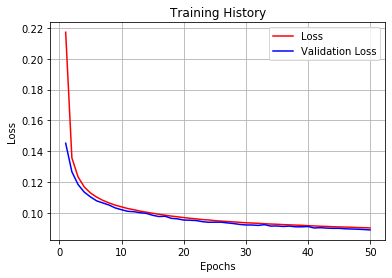

In [15]:
plot_training_history(conv_autoenc_history)

In [61]:
print(f"Final Training Loss: {conv_autoenc_history.history['loss'][-1]}")
print(f"\nFinal Validation Loss: {conv_autoenc_history.history['val_loss'][-1]}")

Final Training Loss: 0.09045226176182429

Final Validation Loss: 0.08914827568531036


The final validation loss is the lowest of all models tested so far, even with only 50 epochs.

In [0]:
decoded_imgs = conv_autoencoder.predict(x_test)

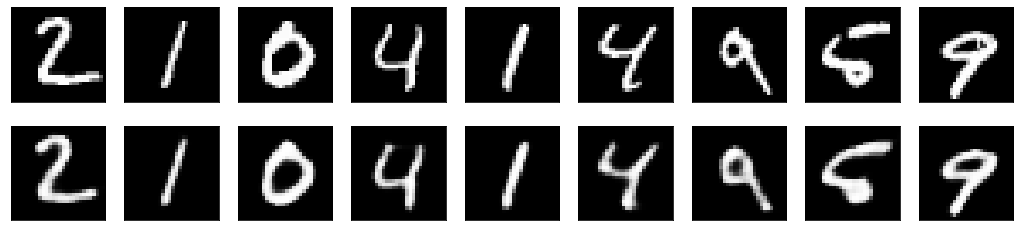

In [23]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Almost perfect reconstruction of the original images.

In [0]:
# Create a model that only encodes images
encoder = Model(input_img, encoded)

# Use this model to transform the input images into encoded representations
encoded_imgs = encoder.predict(x_test)

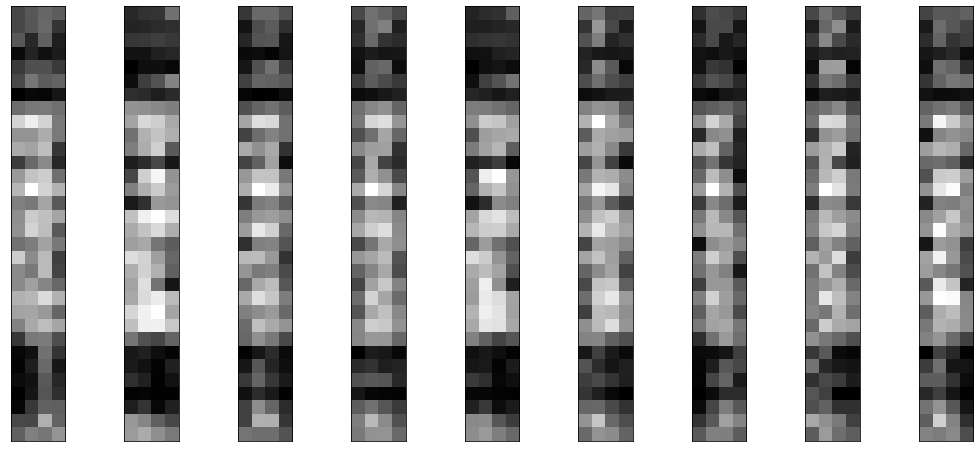

In [32]:
# Plot encoded images
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

This demonstrates the extent of the compression/encoding operation learnt by the autoencoder. Each 784 pixel image has been compressed to a `(4, 4, 8)` dimensional image, which is visualized by reshaping the image to a `(4, 32)` dimensional image.

## Image Denoising

Applying Gaussian noise to the original MNIST digits, and then creating an autoencoder that will learn how to encode and decode these noisy images to denoised versions. 

In [0]:
from keras.datasets import mnist
import numpy as np

In [0]:
(x_train, _), (x_test, _) = mnist.load_data()

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [0]:
# Adding Gaussian noise to each training and test image
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Limit all values to between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

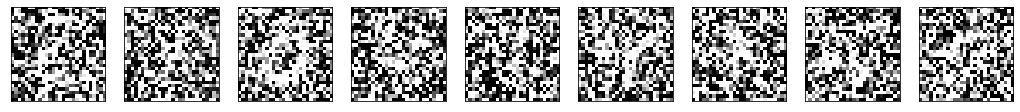

In [43]:
# Visualize the noisy digits
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
# Input layer is still the same
input_img = Input(shape=(28, 28, 1))

In [0]:
# Using more filters per layer to improve quality of reconstructed image
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [0]:
# Representation of the encoder is (7, 7, 32)

In [0]:
# Decoder begins here 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
# Compile 
denoising_autoencoder = Model(input_img, decoded)
denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
# Train for 100 epochs
denoising_history = denoising_autoencoder.fit(x_train_noisy, x_train, 
                                  epochs=100,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(x_test_noisy, x_test))

In [0]:
# How does the model encode and then decode the noisy images?
decoded_imgs = denoising_autoencoder.predict(x_test_noisy)

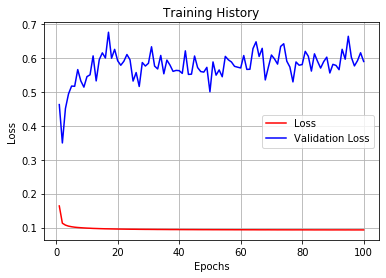

In [53]:
# Training history 
plot_training_history(denoising_history)

Underfitting? There is a large difference between the final validation and training losses. Validation loss is high, training loss is low. High bias?

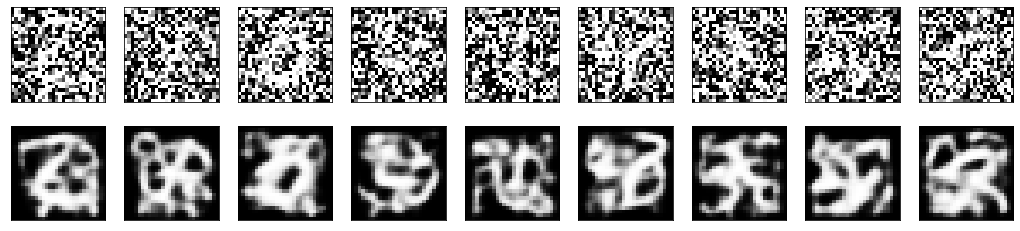

In [60]:
# Display original noisy and decoded/denoised images 
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

This clearly did not work. What did I do wrong?